# Tutorial for Deep Sets model

**IMPORTANT: this tutorial assumes that the member catalogue, cluster parameters, Gaia credentials and isochrone data have been set up. If this is not the case, follow the steps in the 'Data preparation' sections of the README.md in the same directory as this tutorial.**

This notebook walks through the steps for using a Deep Sets model to find additional open cluster members. It includes the data preparation, training of the model and a demonstration of some results. To decrease the runtime of this tutorial, we only show the steps for a single open cluster, NGC 752. This is sufficient for instructive purposes, but a general model that can be applied on unseen clusters needs to be trained on multiple clusters.

NGC 752 is a well-behaved cluster, which allows for a demonstration of the method in favorable conditions. It is also embedded in relatively small amount of field stars, which decreases the runtime.

First we import some basic packages and then we start with the data preparation.

In [1]:
import os
import pandas as pd

## Building datasets

The goal of this section is to build a training and validation dataset for the model to train on. 

### Cluster

The first step is to create a `Cluster` object, which has attributes that relate to the properties of the open cluster. The `Cluster` class requires a dictionary of attributes, which is printed in the next cell.

The required properties and (key) are:
- name (name)
- position (ra, dec)
- proper motions (pmra, pmdec) + errors (pmra_error, pmdec_error)
- parallax (parallax) + errors (parallax_error)
- age (age)
- extinction coefficient (a_v)
- distance (dist)

Note: Although the distance can be calculated with the parallax, we use explicit distances obtained by Cantat-Gaudin et al. (2020). These were determined by a neural network that also took the distribution of the members in the colour-magnitude diagram (CMD) into account. The CMD distribution constrains the distance modulus and thus the distance, which is helpful as the parallax often has relatively large errors and is subject to systematic biases.

In [2]:
from gaia_oc_amd.data_preparation.utils import load_cluster_parameters
from gaia_oc_amd.data_preparation.cluster import Cluster

# The file cluster_parameters.tsv contains cluster properties from Cantat-Gaudin et al. (2020)
data_dir = os.path.join(os.getcwd(), 'data')
cluster_path = os.path.join(data_dir, 'cluster_parameters.csv')

cluster_name = 'NGC_752'
cluster_params = load_cluster_parameters(cluster_name, cluster_path)

print(cluster_params)

cluster = Cluster(cluster_params)

{'name': 'NGC_752', 'ra': 29.223, 'dec': 37.794, 'pmra': 9.81, 'pmdec': -11.713, 'pmra_error': 0.272, 'pmdec_error': 0.266, 'parallax': 2.239, 'parallax_error': 0.071, 'age': 9.07, 'a_v': 0.07, 'dist': 483.0}


### Cone search

Now that we have cluster properties, we can download sources from the Gaia archive that have similar properties and which therefore might be members of the cluster. We also want to include some non-members, such that the model can be trained with both positive and negative examples of open cluster members. 

The `cone_search` function uses the `astroquery` package to download sources from the Gaia archive by performing a cone search on the cluster(s) provided to it. For a source to be included, it must satisfy 3 conditions:
- Its sky position must be within a projected radius of 60 parsec from the cluster mean
- Its proper motion must be within 10 sigma of the cluster mean
- Its parallax must be within 10 sigma of the cluster mean

These conditions ensure the inclusion of both candidates and (informative) non-members.

In [3]:
# from gaia_oc_amd.data_preparation.query import cone_search

# # The gaia_credentials file contains the username and password to log into the Gaia archive 
# credentials_path = os.path.join(data_dir, 'gaia_credentials')
# cone_search([cluster], data_dir, credentials_path)

The `cone_search` function makes a 'clusters' folder in the `data_dir` and creates a subfolder with the same name as that of the clusters in the list, which is the first argument provided to `cone_search`. In the cluster-specific subfolder, we save a 'cone.vot.gz' file which contains the cone sources in votable format.

We load the cone sources as a `pandas` dataframe with the `load_cone` function. This function also does a few pre-processing steps:
- It adds a value of 0.017 mas to the cone source parallaxes, to take the EDR3 zero-point offset into account
- It corrects the colour and magitude of the sources based on the cluster's extinction coefficient a_v
- It shifts the galactic longitude of some sources if the cluster is located too close to the galactic center (such that sources don't have both l $\approx$ 0 and l $\approx$ 360, which results in bad plots)
- It also gives each source a default membership probability (PMemb) of 0%

In [4]:
from gaia_oc_amd.data_preparation.utils import load_cone

cone_path = os.path.join(data_dir, 'clusters', cluster.name, 'cone.vot.gz')
cone = load_cone(cone_path, cluster)

print(cone.columns)

print(cone.head())

Index(['ra', 'dec', 'parallax', 'pmra', 'pmdec', 'ra_error', 'dec_error',
       'parallax_error', 'pmra_error', 'pmdec_error', 'parallax_pmra_corr',
       'parallax_pmdec_corr', 'pmra_pmdec_corr', 'phot_g_mean_flux',
       'phot_bp_mean_flux', 'phot_rp_mean_flux', 'phot_g_mean_flux_error',
       'phot_bp_mean_flux_error', 'phot_rp_mean_flux_error', 'source_id',
       'phot_g_mean_mag', 'bp_rp', 'l', 'b', 'PMemb'],
      dtype='object')
          ra        dec  parallax       pmra      pmdec  ra_error  dec_error  \
0  26.693694  32.995454  2.298969   7.881857 -12.736208  0.365727   0.405232   
1  26.757029  33.064193  2.866575  11.222099 -11.606536  0.467738   0.445870   
2  26.482585  33.154195  1.607611  10.140906 -13.104076  0.044772   0.054781   
3  26.725262  33.367636  2.929424   9.797949 -13.067316  0.573007   0.412344   
4  27.103295  33.263386  1.581128   8.497052 -12.032267  0.054587   0.051260   

   parallax_error  pmra_error  pmdec_error  ...  phot_rp_mean_flux  \
0   

### Isochrone

Next, we load the isochrone corresponding to the age, initial metallicity and distance of the cluster. The isochrone data can be downloaded here http://stev.oapd.inaf.it/cgi-bin/cmd. The `make_isochrone` function includes the following steps to produce a dataframe with isochrone data.
- It uses the cluster age to retrieve the correct isochrone from the 'isochrones.dat' file
- It corrects the isochrone magnitudes with the distance modulus
- It excludes data for stars beyond the evolutionary stage of the early asymptotic giant branch

As the print statements in the next cell show, the isochrone dataframe contains many columns. For our purposes, we only need two of them: the G magnitude 'phot_g_mean_mag' and the BP-RP colour 'bp_rp'. Note that the 'logAge' is the same as that of the cluster

In [5]:
from gaia_oc_amd.data_preparation.isochrone import make_isochrone

isochrone_path = os.path.join(data_dir, 'isochrones.dat')
isochrone = make_isochrone(isochrone_path, cluster)

print(isochrone.columns)

print(isochrone.head())

Index(['Zini', 'MH', 'logAge', 'Mini', 'int_IMF', 'Mass', 'logL', 'logTe',
       'logg', 'label', 'McoreTP', 'C_O', 'period0', 'period1', 'period2',
       'period3', 'period4', 'pmode', 'Mloss', 'tau1m', 'X', 'Y', 'Xc', 'Xn',
       'Xo', 'Cexcess', 'Z', 'mbolmag', 'phot_g_mean_mag', 'G_BPmag',
       'G_RPmag', 'bp_rp'],
      dtype='object')
          Zini       MH   logAge      Mini   int_IMF   Mass   logL   logTe  \
119264  0.0152  0.01508  9.07007  0.090000  1.081690  0.090 -3.395  3.3647   
119265  0.0152  0.01508  9.07007  0.100000  1.171106  0.100 -3.230  3.3888   
119266  0.0152  0.01508  9.07007  0.111333  1.259357  0.111 -3.085  3.4085   
119267  0.0152  0.01508  9.07007  0.120000  1.319316  0.120 -2.977  3.4227   
119268  0.0152  0.01508  9.07007  0.131662  1.391653  0.132 -2.867  3.4349   

         logg  label  ...        Xc        Xn        Xo  Cexcess        Z  \
119264  5.199      0  ...  0.002746  0.000741  0.006719     -1.0  0.01527   
119265  5.175      0  ...  0.

### Train members

To use this method to find open cluster members, we require a set of already established members from which the model will learn how to identify additional members. For this purpose, we can use membership lists from Cantat-Gaudin et al. (2018). The file at `members_path` was constructed using these lists and contains the source identities and corresponding membership probabilities for members of NGC 752. The function `load_members` has optional arguments for specifying the column names for source identity, corresponding cluster and membership probability.

In [6]:
from gaia_oc_amd.data_preparation.utils import load_members

members_path = os.path.join(data_dir, 'cg18_members.csv')
train_members = load_members(members_path, cluster.name)

print(train_members.head())

print('Mean train member probability:', train_members['PMemb'].mean())

            source_id  PMemb
0  342477226146028928    1.0
1  342451215824120576    1.0
2  342474443007226240    1.0
3  342484269892379264    1.0
4  342480004988278784    1.0
Mean train member probability: 0.9011857707509882


As we want to train our model on sources that are very likely to be members, we determine the source identities of sources that have a 100% probability of being a member. This leaves us with 160 highly probable members.

In [7]:
prob_threshold = 1.0
hp_train_members = train_members[train_members['PMemb'] >= prob_threshold]
hp_train_member_identities = hp_train_members['source_id']

print('Total train members:', len(train_members))
print('High probability train members:', len(hp_train_members))

Total train members: 253
High probability train members: 160


### Comparison members

If available, we can also define some 'comparison' members, which are used to compare against the members obtained by this method.

In [8]:
comparison_members_path = os.path.join(data_dir, 't22_members.csv')
comparison_members = load_members(comparison_members_path, cluster.name)

comparison_member_identities = comparison_members['source_id']
comparison_member_probabilities = comparison_members['PMemb']

print(comparison_members.head())

print('Mean comparison member probability:', comparison_member_probabilities.mean())
print('Total comparison members:', len(comparison_members))

            source_id  PMemb
0  342907341351019904    1.0
1  342907478789972864    1.0
2  342907891106824960    1.0
3  342907921170688896    1.0
4  342908097265261568    1.0
Mean comparison member probability: 0.8302912621359224
Total comparison members: 412


### Dividing cone sources

With the highly probable member identities, the cluster properties and the isochrone, we divide the cone sources into members, candidates and non-members by using the `parse_cone` function. The members and non-members are used for training the model, while the candidates are evaluated after training to see which sources our model identifies as member. If additionally comparison member identities are supplied, these members will also be returned.

The `parse_cone` function selects candidates based on three conditions:
- Separation from the cluster mean in parallax (tuned by `max_r`, the maximum radius in parsec)
- Separation from the cluster mean in proper motion (tuned by `pm_errors`, how many sigma a source may deviate from the mean)
- Separation from the isochrone (tuned by `g_delta` and `bp_rp_delta`, the maximum separation in G magnitude and BP-RP colour repectively)

Each condition also takes the errors of the sources into account such that sources with large errors are still included in the candidates even if they are far away from the cluster mean or the isochrone. How many sigma a source may deviate from the maximum separation is given by `source_errors`.

The `candidates` returned by the `parse_cone` function also include the `members`, so we can also check how the model evaluates these sources. (Of course, the model is trained to recognize the members as such, so we expect that the model identifies most of these sources as member.)

The NGC 752 cone contains relatively few sources, so determining candidates and non-members takes little time. For distant clusters located near the galactic center, cones may contain $\sim 10^{6}$ sources, but cones with $\sim 10^{4}$ - $10^{5}$ sources are most common.

Also note that we now have 153 members and before we had 160. The missing members have source identities that were not found in the cone search.

In [9]:
from gaia_oc_amd.data_preparation.parse_cone import parse_cone

# candidate selection params
max_r = 60.
pm_errors = 5.
g_delta = 1.5
bp_rp_delta = 0.5
source_errors = 3.

members, candidates, non_members, comparison = parse_cone(cluster, cone, isochrone, hp_train_member_identities,
                                                          comparison_ids=comparison_member_identities,
                                                          comparison_probs=comparison_member_probabilities,
                                                          max_r=max_r, 
                                                          pm_errors=pm_errors, 
                                                          g_delta=g_delta, 
                                                          bp_rp_delta=bp_rp_delta, 
                                                          source_errors=source_errors)

print('Members:', len(members))
print('Candidates:', len(candidates))
print('Non members:', len(non_members))
print('Comparison:', len(comparison))

Members: 153
Candidates: 1712
Non members: 1420
Comparison: 408


We can plot the (train) members, candidates and non-members to see their distribution in the relevant properties: sky position, proper motion, parallax, magnitude and colour. The dashed red lines indicate the boundaries for selecting candidates that have negligible errors, meaning that any candidate (orange) selected outside this boundary was included because of their sufficiently large errors.

To keep track of the source sets in one place, we use a `Sources` class. This class requires a members, candidates and non-members set. Optionally, a comparison set can also be provided. If no comparison set i provided, the training members are also used as the comparison members by default. 

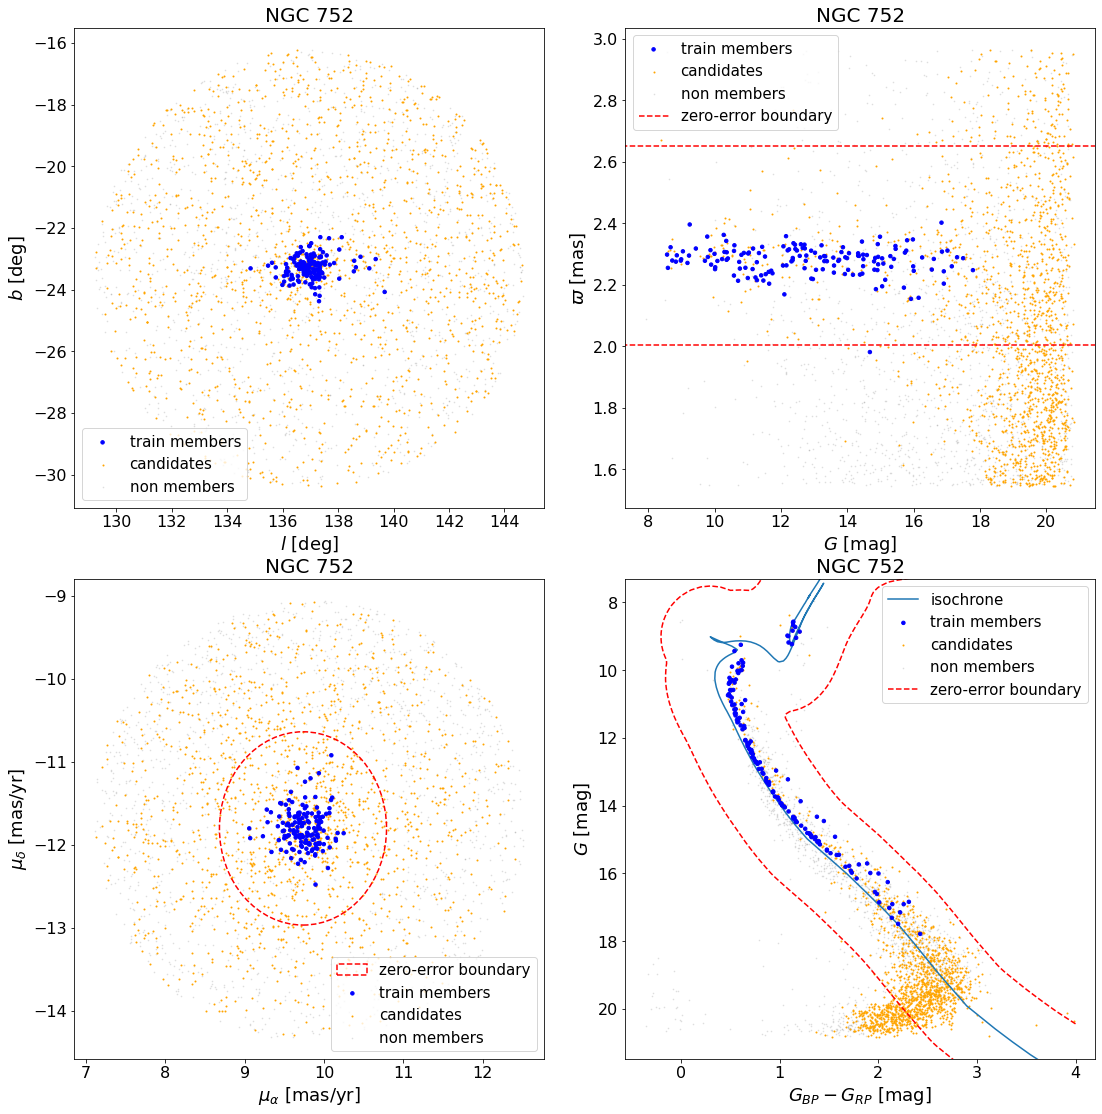

In [10]:
from gaia_oc_amd.data_preparation.sets import Sources
from gaia_oc_amd.candidate_evaluation.visualization import plot_sources

cluster_save_dir = os.path.join(data_dir, 'clusters', cluster.name)
sources = Sources(members, candidates, non_members, comparison_members=comparison)

plot_sources(sources, cluster, cluster_save_dir, isochrone=isochrone, plot_type='candidates')

### Saving and loading sets

To store the cluster object as well as the various sets, we can use the `save_sets` function. To load them, use the `load_sets` function

In [11]:
from gaia_oc_amd.data_preparation.utils import save_sets

save_sets(data_dir, cluster, members, candidates, non_members, comparison=comparison_members)

# from gaia_oc_amd.data_preparation.utils import load_sets
# cluster, members, candidates, non_members, comaprison = load_sets(data_dir, cluster_name)

### Creating a training and validation dataset

With the members and non-members, we can create training and validation instances with the `cluster_datasets` function. This function uses a list of cluster names to load the members, non-members and candidates from respective csv files in `data_dir\clusters\cluster_name`, which are saved there by `save_sets`. Each instance in the training and validation set consist of a tuple containing the model input and a label. 

The model input is made up of a source we want to classify (either a member or a non-member) and a support set (a random set of members). The model is essentially trained to recognize when the source-to-classify is similar enough to the sources in the support set, i.e. to members. The shape of the model input is a [batch $\times$ 5 $\times$ 10] tensor, where 5 is the size of the support set and 10 is twice the number of features used for training (5 for a support set source and 5 for the source-to-classify, which is tiled and concatenated to each source in the support set). 

The five features are:
- `f_r`, separation from the cluster mean in sky position
- `f_pm`, separation from the cluster mean in proper motion
- `f_plx`, separation from the cluster mean in parallax
- `f_c`, colour component of the separation from the isochrone
- `f_g`, G magnitude component of the separation from the isochrone

All but the `f_r` feature are scaled by the zero-error separation, which determines the zero-error boundary. We can visualize the features of a (random) candidate with the `show_features` keyword.

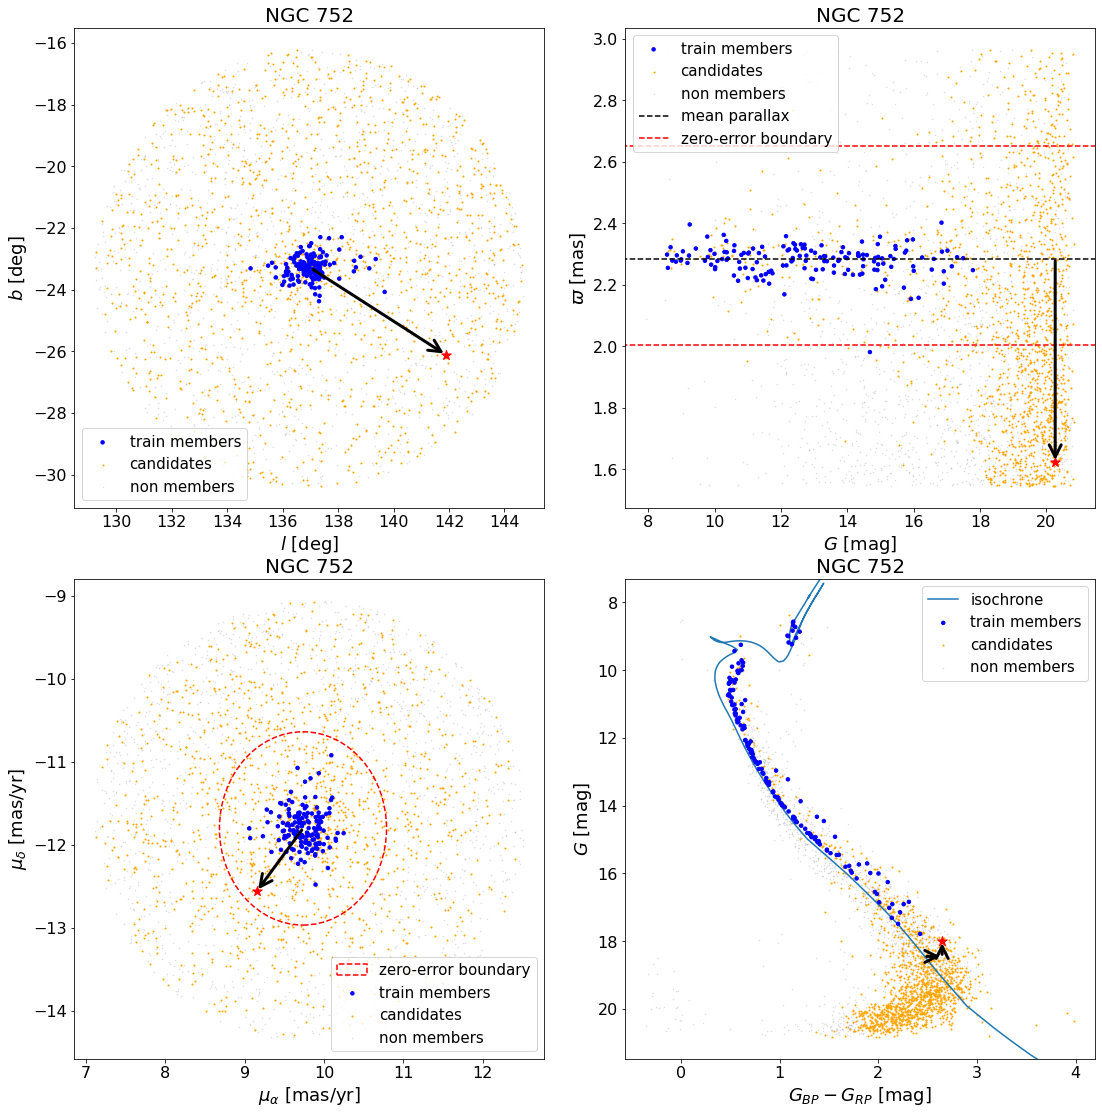

In [12]:
plot_sources(sources, cluster, cluster_save_dir, isochrone=isochrone, plot_type='candidates', 
             show_features=True)

These features are calculated for each source in the `parse_cone` function and added as columns in the dataframes. 

The label indicates the class of the source-to-classify, with [0, 1] for member and [1, 0] for non-member.

In `deep_sets_datasets` the features are standardized, i.e we subtract the mean and divide by the standard deviation. The values of `n_max_members` and `n_max_non_members` determine how many members and non-members to classify are used **per** cluster. Since we only have 153 members and 1420 non-members, selecting 1000 members and 10000 non-members will give duplicate sources to classify. This duplicity is mitigated by the support set, which is random and, with 153 members and a support set size of 5, very likely different for each duplicate source. If we use multiple clusters, we have enough data and smaller values for `n_max_members` and `n_max_non_members` can be used. The RNG seed determines how the train and validation data are distributed.

In [13]:
from gaia_oc_amd.data_preparation.datasets import deep_sets_datasets
from torch.utils.data import DataLoader

# data params
validation_fraction = 0.3
size_support_set = 5
batch_size = 32
max_members = 1000
max_non_members = 10000
training_features = ['f_r', 'f_pm', 'f_plx', 'f_c', 'f_g']

train_dataset, validation_dataset = deep_sets_datasets(data_dir, [cluster.name], 
                                                       training_features=training_features,
                                                       validation_fraction=validation_fraction, 
                                                       max_members=max_members, 
                                                       max_non_members=max_non_members, 
                                                       size_support_set=size_support_set, 
                                                       batch_size=batch_size,
                                                       seed=42)

example = next(iter(train_dataset))

print('Input shape:', example[0].shape)
print('Model input:', example[0][0])
print('Label:', example[1][0])

Creating cluster(s) dataset: 100%|██████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.26it/s]

Input shape: torch.Size([32, 5, 10])
Model input: tensor([[ 0.6391, -0.9572, -0.7765,  4.6985, -6.1050, -1.8198, -1.9400, -1.4353,
         -0.5477,  0.5121],
        [ 0.6391, -0.9572, -0.7765,  4.6985, -6.1050, -1.6004, -1.9049, -1.4389,
         -0.5557,  0.5316],
        [ 0.6391, -0.9572, -0.7765,  4.6985, -6.1050, -1.8056, -1.9793, -1.3569,
         -0.5438,  0.5747],
        [ 0.6391, -0.9572, -0.7765,  4.6985, -6.1050, -1.9671, -1.8471, -1.2029,
         -0.8666,  0.7079],
        [ 0.6391, -0.9572, -0.7765,  4.6985, -6.1050, -1.6069, -1.8410, -1.3132,
         -0.5141,  0.5048]])
Label: tensor([1., 0.])


## Training the model

Now that we have the datasets, we can train the model. We start by instantiating a Deep Sets model, developed by Zaheer et al. (2017), where the 5 in `D5` indicates the number of permutation equivariant layers in the model, which was suggested by Oladosu et al. (2021).

We use 64 hidden units and a 'mean' pooling function. The `x_dim` is determined by the number of features and `out_dim` represents the number of classes (member and non-member).

In [14]:
from gaia_oc_amd.neural_networks.deepsets_zaheer import D5

# model params
hidden_size = 64

model = D5(hidden_size, x_dim=2 * len(training_features), pool='mean', out_dim=2)

Training is done with the `train_model` function, where we train for a maximum of 20 epochs, use a learning rate `lr` and an l2 regularization of `l2`. The `weight_imbalance`, used to mitigate an imbalanced dataset, is the factor by which the loss is multiplied when classifying members. A higher value thus increases the penalty for failing to classify members. The model parameters are saved at the path given by `model_save_path`. 

In [15]:
from gaia_oc_amd.neural_networks.training import train_model
from torch import load

model_save_path = os.path.join(os.getcwd(), 'deep_sets_model_parameters')

# training params
n_epochs = 20
lr = 1e-5
l2 = 1e-5
weight_imbalance = 2.

metrics = train_model(model, train_dataset, validation_dataset, model_save_path, 
                      num_epochs=n_epochs, lr=lr, l2=l2, weight_imbalance=weight_imbalance)

model.load_state_dict(load(model_save_path))

val epoch 0: 100%|████████████████████████████████████████████████████████| 241/241 [00:00<00:00, 961.83it/s, loss=19.2, pos_acc=0.0%, neg_acc=100.0%]


val epoch 1: 100%|████████████████████████████████████████████████████████| 241/241 [00:00<00:00, 954.22it/s, loss=12.3, pos_acc=0.0%, neg_acc=100.0%]


val epoch 2: 100%|███████████████████████████████████████████████████████| 241/241 [00:00<00:00, 993.34it/s, loss=5.95, pos_acc=95.6%, neg_acc=100.0%]


val epoch 3: 100%|███████████████████████████████████████████████████████| 241/241 [00:00<00:00, 963.36it/s, loss=1.88, pos_acc=100.0%, neg_acc=99.7%]


val epoch 4: 100%|█████████████████████████████████████████████████████| 241/241 [00:00<00:00, 1051.43it/s, loss=0.586, pos_acc=100.0%, neg_acc=99.8%]


val epoch 5: 100%|██████████████████████████████████████████████████████| 241/241 [00:00<00:00, 917.64it/s, loss=0.244, pos_acc=100.0%, neg_acc=99.9%]


val epoch 6: 100%|██████████████████████████████████████████████████████| 241/241 [00:00<00:00, 982.13it/s, loss=0.132, pos_acc=100.0%, neg_acc=99.9%]


val epoch 7: 100%|████████████████████████████████████████████████████| 241/241 [00:00<00:00, 933.09it/s, loss=0.0764, pos_acc=100.0%, neg_acc=100.0%]


val epoch 8: 100%|███████████████████████████████████████████████████| 241/241 [00:00<00:00, 1024.65it/s, loss=0.0547, pos_acc=100.0%, neg_acc=100.0%]


val epoch 9: 100%|████████████████████████████████████████████████████| 241/241 [00:00<00:00, 997.12it/s, loss=0.0319, pos_acc=100.0%, neg_acc=100.0%]


val epoch 10: 100%|██████████████████████████████████████████████████| 241/241 [00:00<00:00, 1022.26it/s, loss=0.0241, pos_acc=100.0%, neg_acc=100.0%]


val epoch 11: 100%|███████████████████████████████████████████████████| 241/241 [00:00<00:00, 969.12it/s, loss=0.0163, pos_acc=100.0%, neg_acc=100.0%]


val epoch 12: 100%|███████████████████████████████████████████████████| 241/241 [00:00<00:00, 941.17it/s, loss=0.0128, pos_acc=100.0%, neg_acc=100.0%]


val epoch 13: 100%|██████████████████████████████████████████████████| 241/241 [00:00<00:00, 994.47it/s, loss=0.00958, pos_acc=100.0%, neg_acc=100.0%]


val epoch 14: 100%|█████████████████████████████████████████████████| 241/241 [00:00<00:00, 1058.33it/s, loss=0.00729, pos_acc=100.0%, neg_acc=100.0%]


val epoch 15: 100%|██████████████████████████████████████████████████| 241/241 [00:00<00:00, 1013.87it/s, loss=0.0054, pos_acc=100.0%, neg_acc=100.0%]


val epoch 16: 100%|█████████████████████████████████████████████████| 241/241 [00:00<00:00, 1012.06it/s, loss=0.00407, pos_acc=100.0%, neg_acc=100.0%]


val epoch 17: 100%|█████████████████████████████████████████████████| 241/241 [00:00<00:00, 1029.69it/s, loss=0.00335, pos_acc=100.0%, neg_acc=100.0%]


val epoch 18: 100%|██████████████████████████████████████████████████| 241/241 [00:00<00:00, 951.43it/s, loss=0.00289, pos_acc=100.0%, neg_acc=100.0%]


val epoch 19: 100%|██████████████████████████████████████████████████| 241/241 [00:00<00:00, 1021.62it/s, loss=0.0024, pos_acc=100.0%, neg_acc=100.0%]


<All keys matched successfully>

We can visualize the training process by plotting the evolution of the loss value and the classification accuracy of both the members and non-members. In this case, the members and non-members are classified with near perfect accuracy. The train loss is higher than the validation loss because of dropout layers in the model, which are deactivated when the model is applied to the validation dataset.

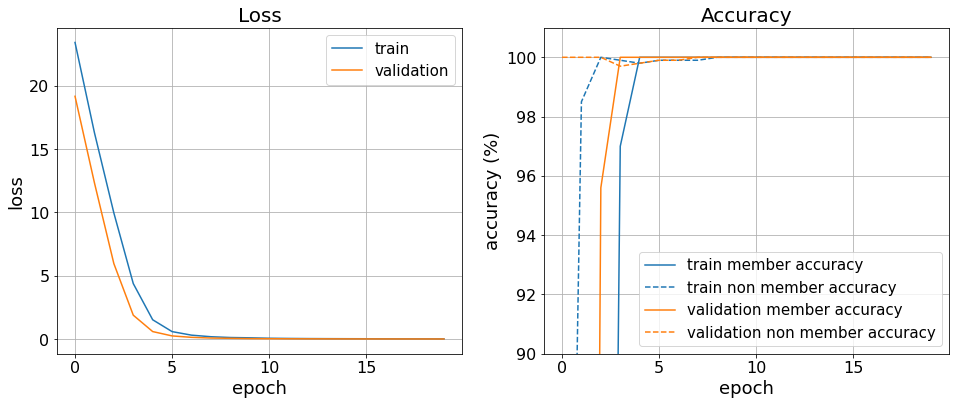

In [16]:
from gaia_oc_amd.candidate_evaluation.visualization import plot_loss_accuracy

plot_loss_accuracy(metrics, cluster_save_dir)

### Evaluating candidates

Once the model is trained, we can use it to evaluate the candidates.

To take the errors in the astrometric and photometric properties of the candidates into account, we resample the training features of each candidate a number of times, based on the uncertainties and correlations of its properties. The smaller the errors of the candidate properties, the more compact the sample distribution will be. We then interpret the fraction of samples that were identified by the model as member as the candidate's membership probability. 

We use a `Features` class to give the `calculate_probabilities` function access to the functions needed for recalculating the training features with the resampled candidate properties. The `calculate_probabilities` function also provides each sample with its own support set. What is returned are the membership probabilities of the candidates.

We give the probabilities to the candidate set in the `Sources` class, so that they can be used for plots. We also overwrite the csv file where the candidates were stored to now include the probabilites as well.

Depending on the number of candidates and samples, this evaluation process may take less than or minute or up to a few hours for $\sim$$10^{5}$ candidates. 

In [17]:
import torch
from gaia_oc_amd.data_preparation.features import Features
from gaia_oc_amd.candidate_evaluation.probabilities import calculate_probabilities

model.load_state_dict(torch.load(model_save_path))

# evaluation params
n_samples = 40

fields = Features(training_features, cluster, isochrone)

sources.candidates['PMemb'] = calculate_probabilities(sources.candidates, model, sources, 
                                                      fields, n_samples, size_support_set)

candidates_save_path = os.path.join(cluster_save_dir, 'candidates.csv')
sources.candidates.to_csv(candidates_save_path)

Evaluating candidate samples: 100%|███████████████████████████████████████████████████████████████████████████████████| 40/40 [00:26<00:00,  1.50it/s]


## Results

With the membership probabilities of the candidates determined, we can check their distribution and see how they compare against other member sets.

We can plot the evaluated candidates above a certain probability with the same function as we used for plotting the candidates distribution. This time we use `plot_type='new_members'` to indicate that we want to plot the obtained members. We specify a `prob_threshold=0.8` to show the candidates with a membership probability of 80% or higher.

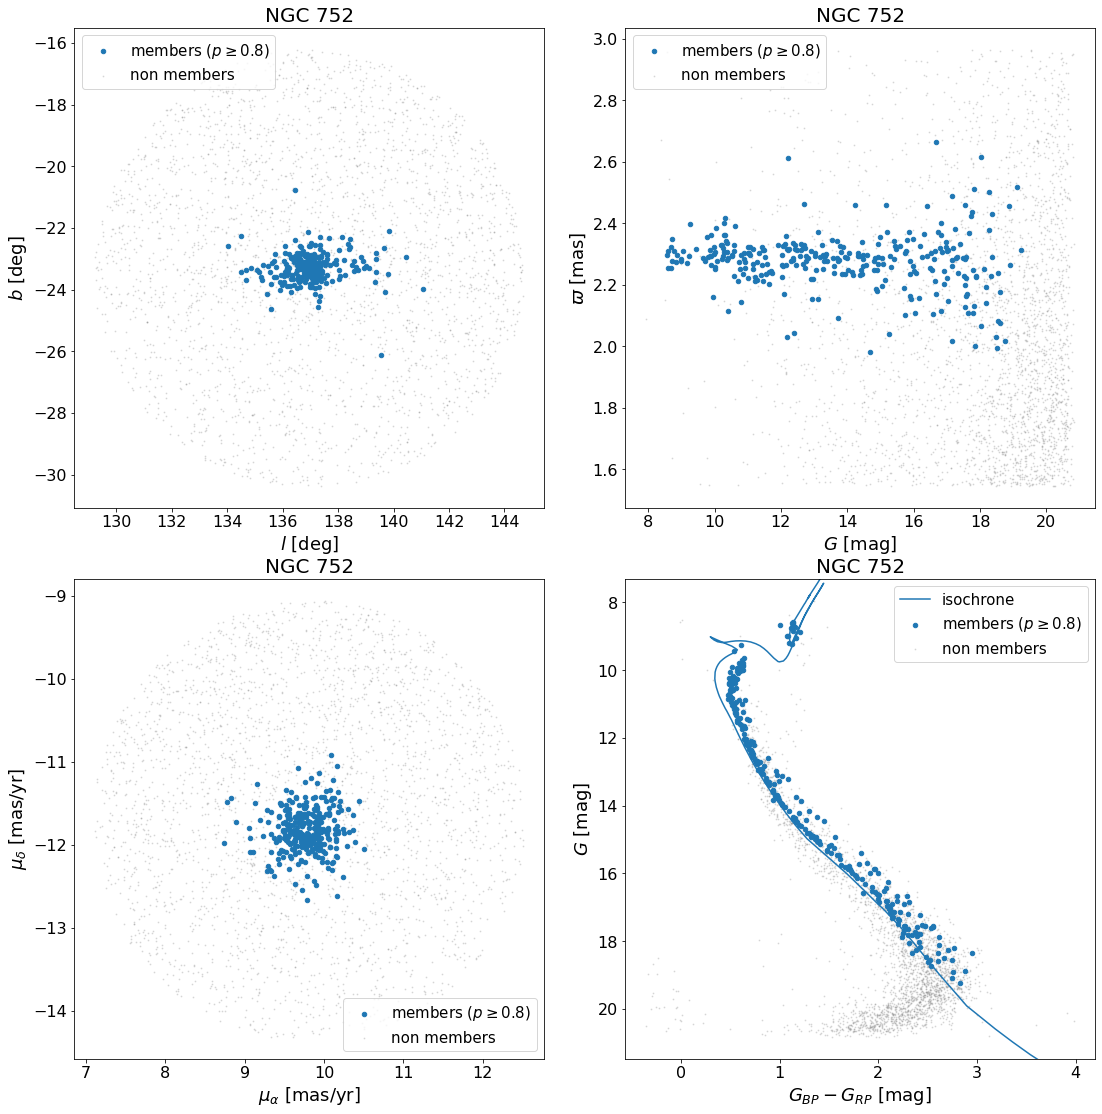

In [18]:
plot_sources(sources, cluster, cluster_save_dir, isochrone, plot_type='new_members', prob_threshold=0.8)

### Compare members

We can compare the obtained members to the comparison set (which we stored in the `Sources` class) in a number of different ways.

We show five plots, including:
- A density profile, which shows how well a King model fits the projected density distribution of candidates with a membership probability of 10% or higher.
- A mass segregation profile, which shows the degree to which the distribution of the $N_{MST}$ most massive members is more clustered than a distribution of $N_{MST}$ random members. A value higher than 1 means that the $N_{MST}$ most massive members are more tightly clustered.
- A venn diagram, showing the overlap between the different member sets for members above a 10%, 50% and 90% probability threshold. Red are comparison members not found by our method, green are members we obtain which are not in the comparison set and light brown is the overlap. 
- A 'confusion matrix', which shows how boths sets compare in the probabilities they ascribe to the members.
- Another `plot_sources`, with this time only the comparison members and the candidates with probabilities above 10%. Darker colours indicate a higher membership probability. 

In [19]:
from gaia_oc_amd.candidate_evaluation.visualization import plot_density_profile, plot_mass_segregation_profile, plot_venn_diagram, plot_confusion_matrix

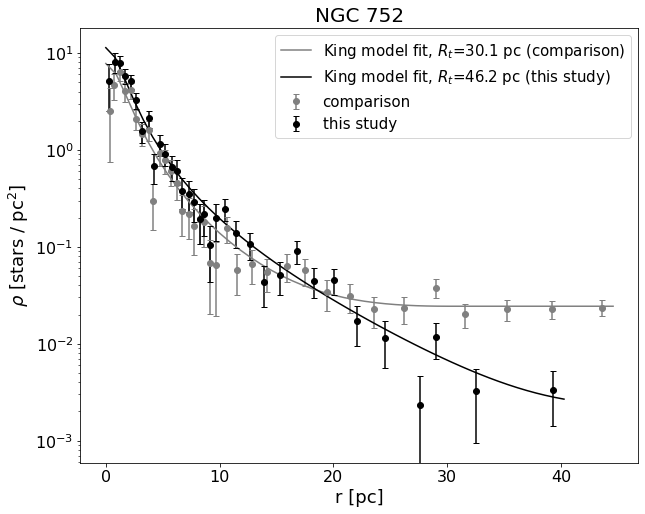

In [20]:
plot_density_profile(sources, cluster, cluster_save_dir)

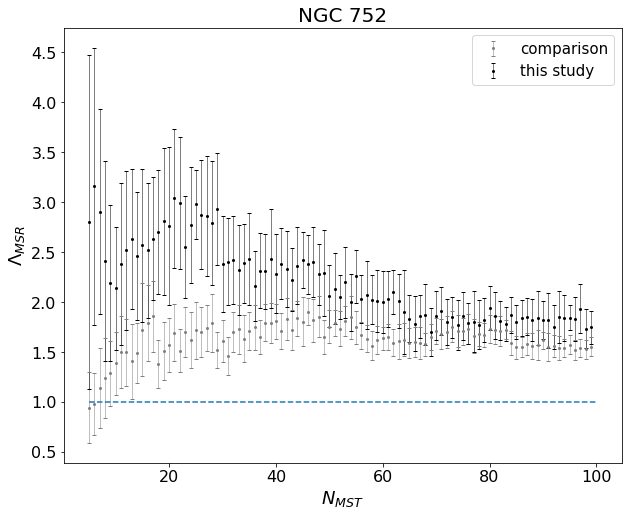

In [21]:
plot_mass_segregation_profile(sources, cluster, cluster_save_dir)

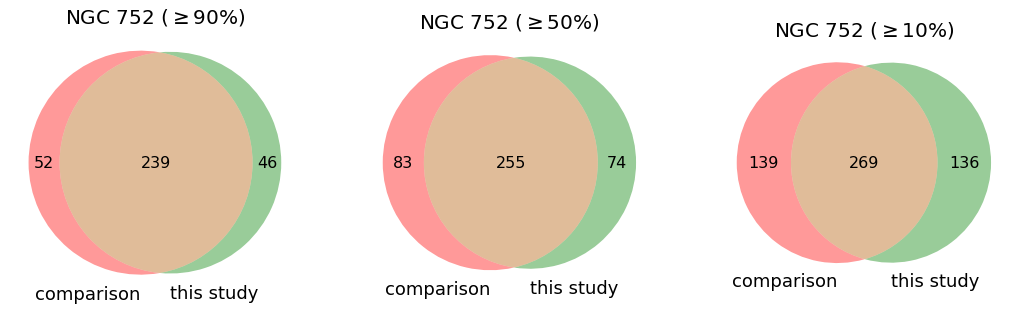

In [22]:
plot_venn_diagram(sources, cluster, cluster_save_dir)

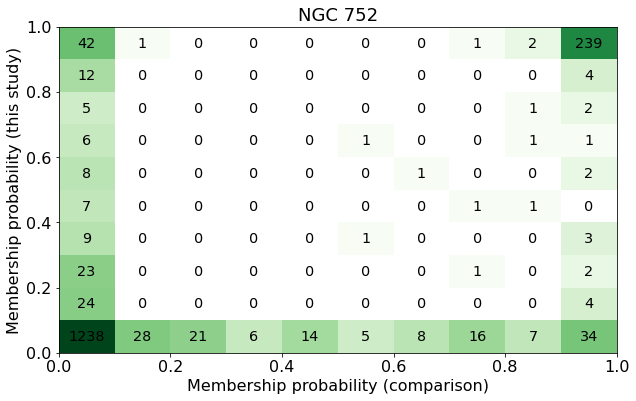

In [23]:
plot_confusion_matrix(sources, cluster, cluster_save_dir)

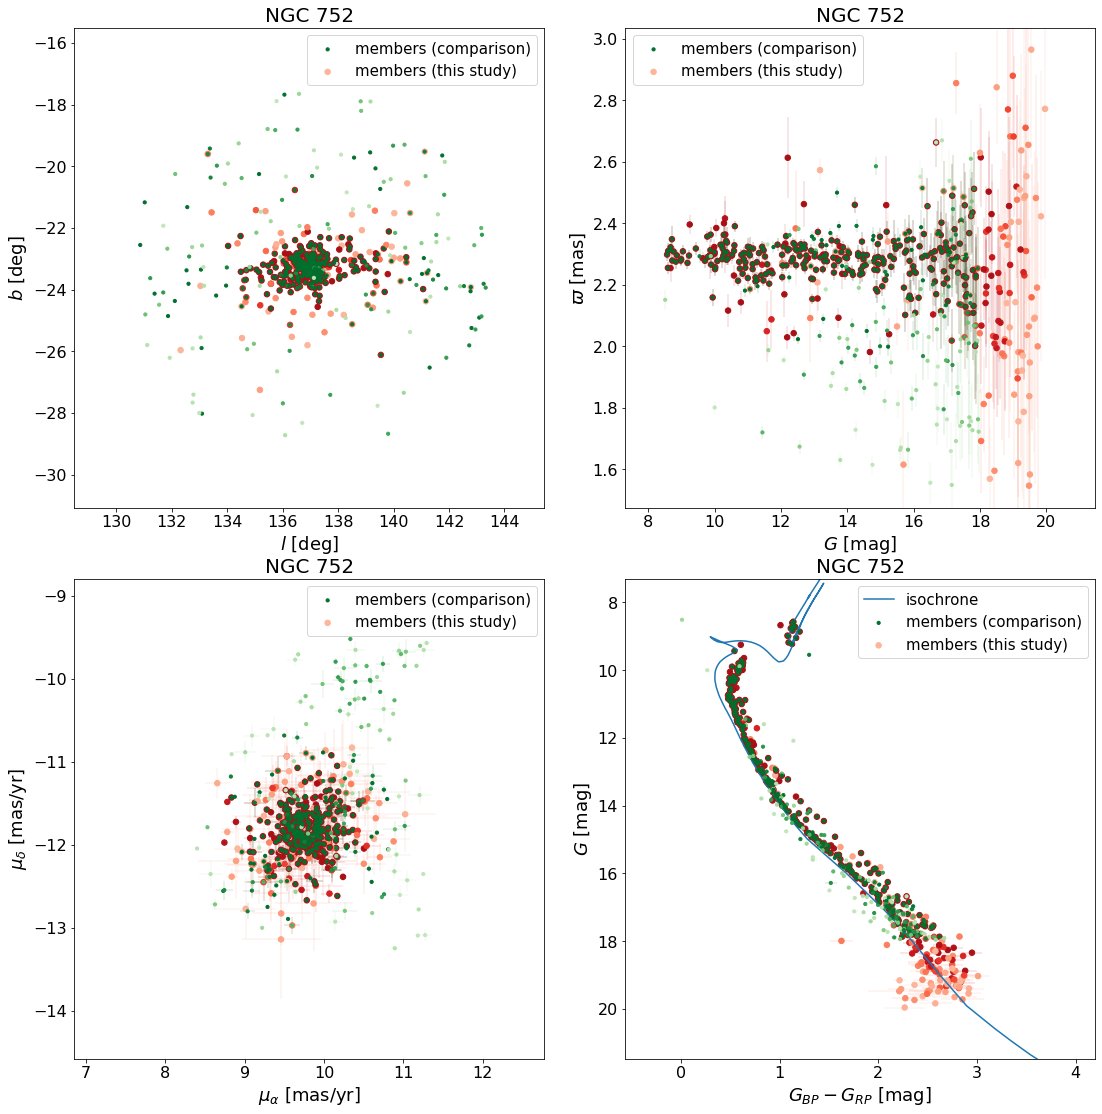

In [24]:
plot_sources(sources, cluster, cluster_save_dir, isochrone, plot_type='comparison')